In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from load_data import (load_tourism,
                       create_train_dataloader,
                       create_backtest_dataloader,
                       create_test_dataloader)
from sur_ts import SurrogateTimeSeriesTransformerConfig, SurrogateTimeSeriesTransformer
import pandas as pd 


/Users/panda/anaconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
freq = '1M'
train_dataset, test_dataset, lags_sequence, time_features = load_tourism()
prediction_length = 24


config = SurrogateTimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

In [156]:
test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

test_dates = test_dataset['start'][-config.context_length - config.prediction_length - max(config.lags_sequence):]

model_path = 'model2'

sur_model = SurrogateTimeSeriesTransformer.from_pretrained(model_path)


In [164]:
# get the time step ranges
period_len_lst = [len(test_dataset[i]['target']) for i in range(len(test_dataset))]
period_range_lst = [pd.period_range(test_dataset['start'][i], periods=j, freq='M') for i, j in enumerate(period_len_lst)]
period_range_lst = [period_range[-config.context_length - config.prediction_length - max(config.lags_sequence):] for period_range in period_range_lst]
# get the target values
target_value_lst = [test['target'] for test in test_dataset]
target_value_lst = [target[-config.context_length - config.prediction_length - max(config.lags_sequence):] for target in target_value_lst]


print(len(period_range_lst))
print(len(period_range_lst[0]))
print(len(target_value_lst))
print(len(target_value_lst[0]))


366
109
366
109


In [5]:
from accelerate import Accelerator
import torch
from transformers import AutoModel

accelerator = Accelerator()
device = accelerator.device

sur_model.to(device)

SurrogateTimeSeriesTransformer(
  (model): TimeSeriesTransformerForPrediction(
    (model): TimeSeriesTransformerModel(
      (scaler): TimeSeriesMeanScaler()
      (embedder): TimeSeriesFeatureEmbedder(
        (embedders): ModuleList(
          (0): Embedding(366, 2)
        )
      )
      (encoder): TimeSeriesTransformerEncoder(
        (value_embedding): TimeSeriesValueEmbedding(
          (value_projection): Linear(in_features=22, out_features=32, bias=False)
        )
        (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
        (layers): ModuleList(
          (0-3): 4 x TimeSeriesTransformerEncoderLayer(
            (self_attn): TimeSeriesTransformerAttention(
              (k_proj): Linear(in_features=32, out_features=32, bias=True)
              (v_proj): Linear(in_features=32, out_features=32, bias=True)
              (q_proj): Linear(in_features=32, out_features=32, bias=True)
              (out_proj): Linear(in_features=32, out_features=32, bias=True)


In [20]:
import numpy as np
sur_model.eval()

# forecasts = []
outputs_lst = []

for batch in test_dataloader:
    outputs = sur_model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
        # future_observed_mask=None,
    )
    # forecasts.append(outputs.sequences.cpu().numpy())
    outputs_lst.append(outputs)
forecasts = np.vstack([outputs.sequences.cpu().numpy() for outputs in outputs_lst])
attention_outputs = np.vstack([outputs.attention_output.cpu().numpy() for outputs in outputs_lst])
attention_weights = np.vstack([outputs.attention_weights.cpu().numpy() for outputs in outputs_lst])

print(forecasts.shape)

(366, 100, 24)


In [21]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

print(f"MASE prediction: {np.mean(mase_metrics)}")
print(f"sMAPE prediction: {np.mean(smape_metrics)}")

MASE prediction: 1.5800997819297815
sMAPE prediction: 0.19803835462938574


In [22]:
print("attention_outputs shape:", attention_outputs.shape)
print("attention_weights shape:", attention_weights.shape)

attention_outputs shape: (366, 24, 32, 85)
attention_weights shape: (366, 24, 85)


In [136]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def draw_bar_plot(dates, values, forecast_idx, forecasted):
    # Convert date strings to datetime objects if they are not already
    dates = pd.to_datetime(dates)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(dates, values, width=20, label='past time contribution')  # Adjust width as needed based on granularity
    ax.bar(dates[forecast_idx], forecasted, width=10, label='forecasted value')
    ax.bar(dates[forecast_idx-1],values.sum(), width=10,label='interpretation sum')
    
    # Set x-axis major locator and formatter based on the specified granularity
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.xticks(rotation=45) # Rotate for better readability
    
    # Auto-format the x-axis labels for better readability
    plt.gcf().autofmt_xdate()
    
    plt.xlabel('Date')
    plt.ylabel('Contribution Value')
    plt.title(f'Contributions over months')
    plt.legend()
    
    plt.show()


In [151]:
# attention_interp.shape
attention_interp = attention_outputs.sum(axis=-2)
# attention_interp = attention_weights
idx = 334
forecast_idx = 2
example = attention_interp[idx,forecast_idx,:]
test_dates = period_range_lst[idx]
# mean forecasted value (100 are generated from the distribution, so we need to average over them)
forecasted = forecasts.mean(1)[idx, forecast_idx]
print("forecasted", forecasted)
print("interpreted sum", example.sum())


forecasted 5697.8154
interpreted sum 4701.3936


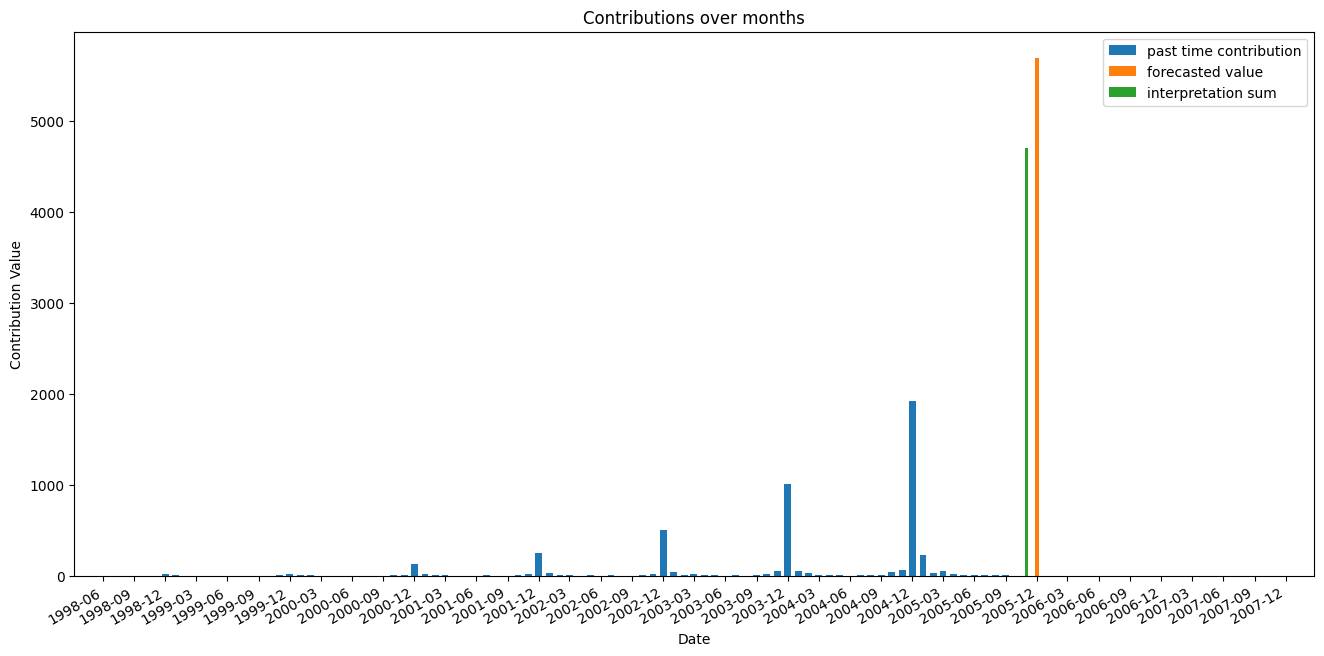

In [152]:
test_times = [dateperiod.to_timestamp() for dateperiod in test_dates]
values = example
len_values = len(values)
pad_len = len(test_times) - len_values
values = np.pad(values, (0, pad_len), mode='constant')
draw_bar_plot(dates=test_times, values=values, forecast_idx=len_values+forecast_idx, forecasted=forecasted) 

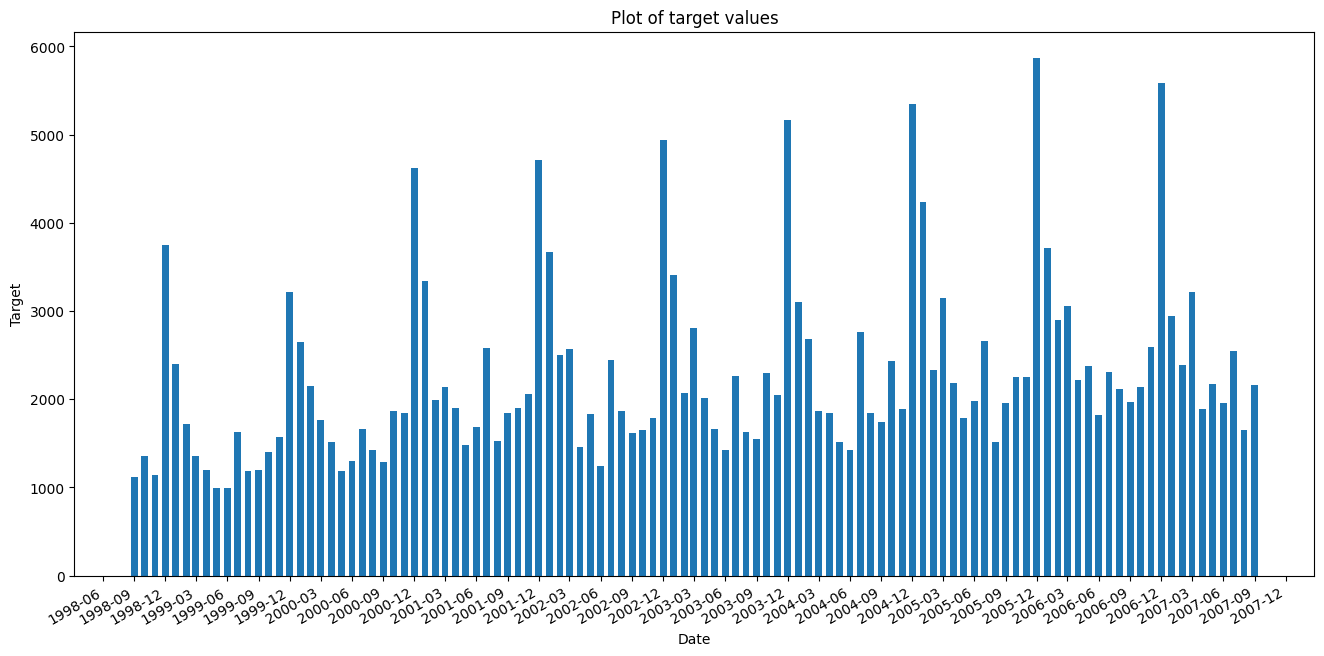

In [172]:
import matplotlib.pyplot as plt

# Extract the values from the past_values variable
target_values = target_value_lst[idx]

# Create a bar plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(pd.to_datetime(test_times), target_values, width=20)

# Set x-axis major locator and formatter based on the specified granularity
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45) # Rotate for better readability

# Auto-format the x-axis labels for better readability
plt.gcf().autofmt_xdate()
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Plot of target values')

# Show the plot
plt.show()


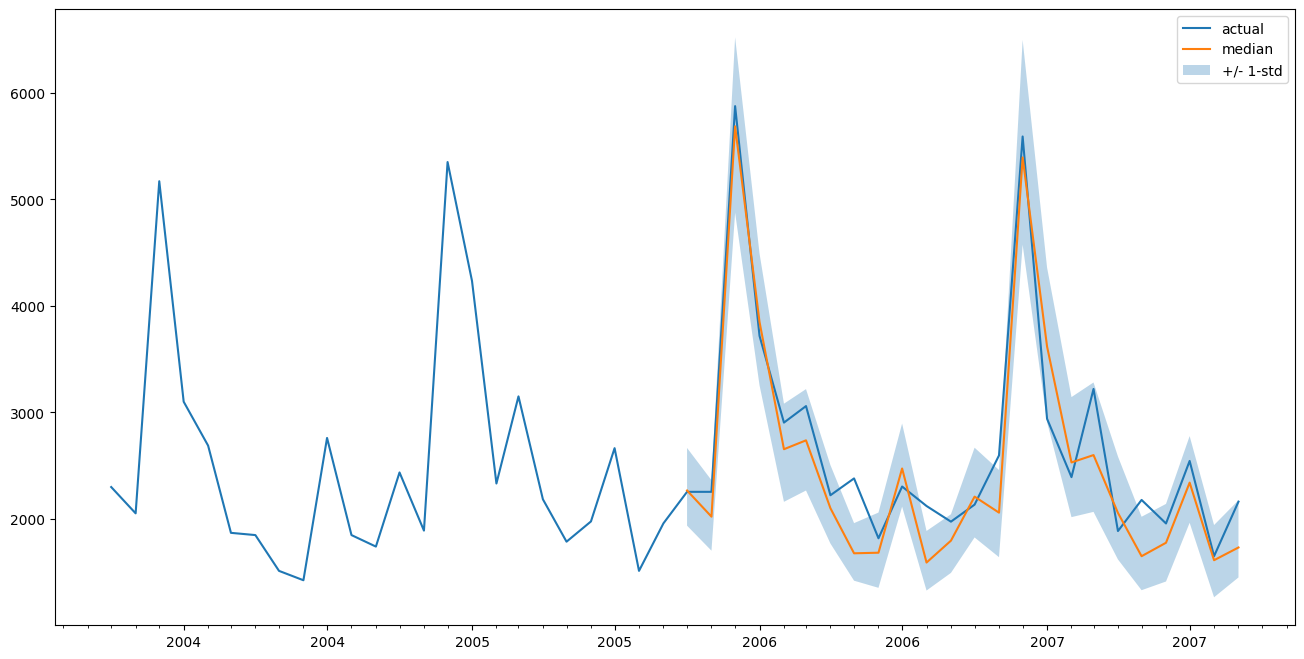

In [173]:
import matplotlib.dates as mdates
import pandas as pd
from gluonts.dataset.field_names import FieldName

def plot(ts_index):
    fig, ax = plt.subplots(figsize=(16, 8))

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()
plot(334)
